In [104]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
import math
import sympy
from numpy.linalg import inv
from sympy import diff
from sympy import Symbol
import time

In [105]:
def prediction(x, F, sqrtU):
    return np.matmul(F, x) + np.matmul(sqrtU, np.random.randn(sqrtU.shape[1]))

def observation(x, H, sqrtV):
    return np.matmul(H, x) + np.matmul(sqrtV, np.random.randn(sqrtV.shape[1]))

def Kalman_filter(y, m0, P0, F, H, U, V, n, xdim, delta):
    # Updated mean and variance
    mu = np.zeros((xdim, n))
    Pu = np.zeros((xdim, xdim, n))
    # Predicted mean and variance
    mp = np.zeros((xdim, n))
    Pp = np.zeros((xdim, xdim, n))
    
    # Predicted mean and variance t=1
    mp[:, 0] = np.matmul(F, m0)
    Pp[:, :, 0] = np.matmul(np.matmul(F, P0), F.transpose()) + U
    
    # Updated mean and variance t=1
    z = y[:, 0] - np.matmul(H, mp[:, 0])
    S = np.matmul(np.matmul(H, Pp[:, :, 0]), H.transpose()) + V
    K = np.matmul(np.matmul(Pp[:, :, 0], H.transpose()), inv(S))
    mu[:, 0] = mp[:, 0] + np.matmul(K, z)
    Pu[:, :, 0] = np.matmul(np.eye(xdim) - np.matmul(K, H), Pp[:, :, 0])
    
    # Kalman filter t=2-n
    for k in np.arange(1,n):
        # Prediction
        mp[:, k] = np.matmul(F, mu[:, k-1])
        Pp[:, :, k] = np.matmul(np.matmul(F, Pu[:, :, k-1]), F.transpose()) + U
        # Update
        if k < n - delta:
            z = y[:, k] - np.matmul(H, mp[:, k])
            S = np.matmul(np.matmul(H, Pp[:, :, k]), H.transpose()) + V
            K = np.matmul(np.matmul(Pp[:, :, k], H.transpose()), inv(S))
            mu[:, k] = mp[:, k] + np.matmul(K, z)
            Pu[:, :, k] = np.matmul(np.eye(xdim) - np.matmul(K, H), Pp[:, :, k])
        else:
            mu[:, k] = mp[:, k]
            Pu[:, :, k] = Pp[:, :, k]
        
    return mp, Pp, mu, Pu

def generate_data(F, H, sqrtU, sqrtV, n, xdim, ydim):
    x = np.zeros((xdim, n))
    y = np.zeros((ydim, n))
    x[:, 0] = prediction(x0, F, sqrtU) #state time 1
    y[:, 0] = observation(x[:, 0], H, sqrtV) #ob time 1
    for k in range(1,n):
        x[:, k] = prediction(x[:, k-1], F, sqrtU)
        y[:, k] = observation(x[:, k], H, sqrtV)
    return x, y

def genH(H,n):
    Hv = np.zeros((n, n+1))
    for i in np.arange(n):
        Hv[i][i+1] = H
    return Hv

def genP(F,n):
    P = np.zeros((n+1, n+1))
    P[0][0] = P0
    for i in np.arange(1,n+1):
        P[i][i] = np.matmul(np.matmul(F, [P[i-1][i-1]]), F.transpose()) + U
    for j in np.arange(0,n+1):    
        for k in np.arange(0,n+1):  
            if j < k:
                P[j][k] =  np.matmul(F, [P[j][k-1]])
                P[k][j] = P[j][k]
    return P

In [106]:
# Dimensions of the state and observation
xdim = 1
ydim = 1

# Initial state
x0 = np.array([[0]])

# Observation matrix = N(yn;xn,1)
H = np.array([[1]]) #identity observe

# Observation noise
sigy=20  #sigy = 20
sqrtV = np.array([[sigy]]) #sigma ob
V = np.matmul(sqrtV, sqrtV.transpose()) #observation variance

# Prior = N(x0;0,1)
m0 = np.array([0.0]) #m0=0
sig0 =400 #prior sigma , sig0=400
P0 = np.array([sig0**2]) #large uncertainty of initial state sig0^2 

# Evolution = N(xn+1;xn,1)
dt = 1.0
F = np.array([[1]]) #identity evolution
sigx = 1 #sigx=1
sqrtU = np.array([[sigx]]) #sigma evolve
U = np.matmul(sqrtU, sqrtU.transpose()) #variance evolve
# Time steps
n = 50
delta = 0 

# Data generation
(x, y) = generate_data(F, H, sqrtU, sqrtV, n, xdim, ydim)

In [107]:
Mu0 = np.zeros(n) #mean x0|y1:n when n=1,...,n
P00 = np.zeros(n) #var x0|y1:n when n=1,...,n
Mun = np.zeros(n) #mean xn|y1:n when n=1,...,n
Pnn = np.zeros(n) #var xn|y1:n when n=1,...,n
P0n = np.zeros(n) #cov x0,xn|y1:n when n=1,...,n
Mcco = np.zeros(n) #coef of mean xn|x0,y1:n 
Mcre = np.zeros(n) #remainder of mean xn|x0,y1:n 
Pc = np.zeros(n) #var of xn|x0,y1:n 
for h in np.arange(1,n+1):
    P = genP(F,h)
    Hv = genH(H,h)
    Vv = np.zeros((h, h))
    for i in np.arange(h):
        Vv[i][i] = V
    S = np.matmul(np.matmul(Hv, P),Hv.transpose()) +Vv
    K = np.matmul(np.matmul(P, Hv.transpose()),inv(S)) 
    M = []
    M.append(m0)
    for i in np.arange(h):
        M.append(np.matmul(F,M[i]))
    M = np.array(M)  #array of old mean
    Mu0[h-1] = np.matmul((np.identity(h+1) - np.matmul(K,Hv))[0], M) + np.matmul(K[0],y[0][0:h]) #mean x0|y1:n
    Mun[h-1] = np.matmul((np.identity(h+1) - np.matmul(K,Hv))[h], M) + np.matmul(K[h],y[0][0:h]) #mean xn|y1:n
    P00[h-1] = np.matmul((np.identity(h+1) - np.matmul(K,Hv))[0],P[:,[0]])
    P0n[h-1] = np.matmul((np.identity(h+1) - np.matmul(K,Hv))[0],P[:,[h]])
    Pnn[h-1] = np.matmul((np.identity(h+1) - np.matmul(K,Hv))[h],P[:,[h]])
    Mcco[h-1] = P0n[h-1]/P00[h-1]
    Mcre[h-1] = Mun[h-1] - (Mcco[h-1]* Mu0[h-1])
    Pc[h-1] = Pnn[h-1] - (Mcco[h-1]*P0n[h-1])

In [108]:
a=-2
b=2

#rv-rv case
cred = norm(Mun, Pnn**0.5).cdf(b) - norm(Mun, Pnn**0.5).cdf(a) 

#duv-duv case
B = [] #maximum value of function = credibility duv-duv case
for i in np.arange(n):
    if a <= Mun[i] <= b:
        B.append(1)
    elif Mun[i] < a:
        B.append(math.exp((-1/(2*(Pnn[i])))*((a-Mun[i])**2 ))) #f(a)
    else :
        B.append(math.exp((-1/(2*(Pnn[i])))*((b-Mun[i])**2 ))) #f(b)
        
X = [] #lower bound for credibility duv-duv case
for i in np.arange(n):
    if a <= Mun[i] <= b:
        if abs(a-Mun[i]) <= abs(b-Mun[i]):
            X.append(1-(math.exp((-1/(2*(Pnn[i])))*((a-Mun[i])**2 )))) #1-f(a)
        else :
            X.append(1-(math.exp((-1/(2*(Pnn[i])))*((b-Mun[i])**2 )))) #1-f(b)
    elif Mun[i] < a:
        X.append(0) #1-f(mean)
    else :
        X.append(0) #1-f(mean)
        
#duv-rv case
D = [] #maxumum value of function = credibility duv-rv case
for i in np.arange(n):
    def f(x):
        return (math.exp((-1/(2*P00[i]))*((x-Mu0[i])**2 )))* (norm(Mcco[i]*x + Mcre[i], Pc[i]**0.5).cdf(b) - 
                                                      norm(Mcco[i]*x + Mcre[i], Pc[i]**0.5).cdf(a))
    j = minimize(lambda x: -f(x),a).x   #try to find how to set initial guess? #set intial guess =a
    D.append(f(j))  

Y = [] #lower bound for credibility duv-rv case
for i in np.arange(n):
    def f(x):
        return 1- ((math.exp((-1/(2*P00[i]))*((x-Mu0[i])**2 )))* (1 - norm(Mcco[i]*x + Mcre[i], Pc[i]**0.5).cdf(b) + 
                                                          norm(Mcco[i]*x + Mcre[i], Pc[i]**0.5).cdf(a)))
    j = minimize(f,a).x   #try to find how to set initial guess? #set intial guess =a if set a+b/2 will stuck at local min
    Y.append(f(j))  

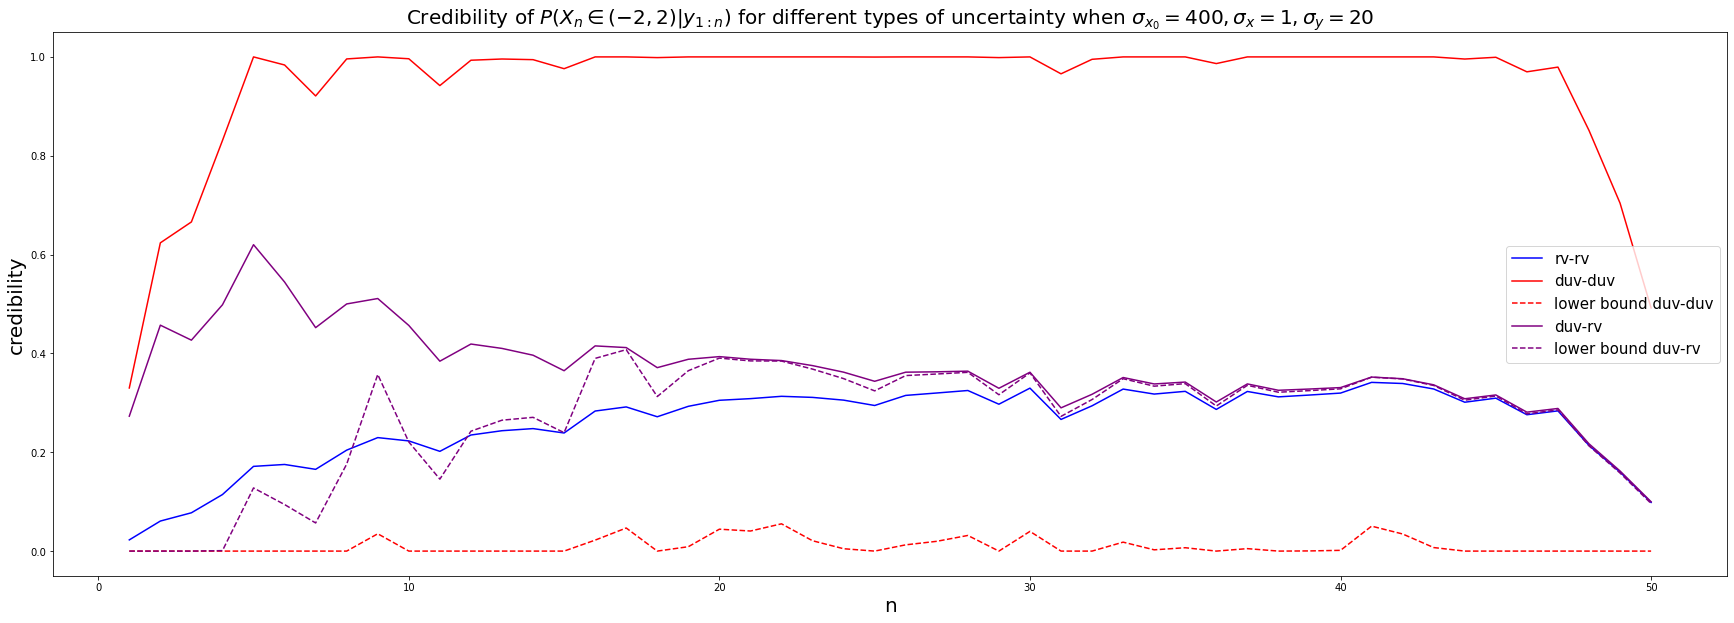

In [109]:
plt.figure(figsize=(30,10))
plt.title("Credibility of $P(X_n \in (-2,2)| y_{1:n})$ for different types of uncertainty when $\sigma_{x_{0}} = 400, \sigma_{x}=1,\sigma_{y}=20$", fontsize = 20)
plt.xlabel('n',fontsize=20)
plt.ylabel('credibility', fontsize=20)
plt.plot(np.arange(start=1, stop=n+1, step=1),cred,linestyle='-',color='blue',label='rv-rv')
plt.plot(np.arange(start=1, stop=n+1, step=1),B,linestyle='-',color='red',label='duv-duv')
plt.plot(np.arange(start=1, stop=n+1, step=1),X,linestyle='--',color='red',label='lower bound duv-duv')
plt.plot(np.arange(start=1, stop=n+1, step=1),D,linestyle='-',color='purple',label='duv-rv')
plt.plot(np.arange(start=1, stop=n+1, step=1),Y,linestyle='--',color='purple',label='lower bound duv-rv')
plt.legend(loc='best',fontsize=15)
plt.show()

# Comparison of using time for finding p(xn|y1:n,x0) between KF iteration and KS with marginalization

### Traditional method (KF iteration)

In [110]:
start1 = time.time()
mp = [np.matmul(F,[Symbol('x')])] #m1|0
Pp = np.zeros((xdim, xdim, n))
Pp[:, :, 0] = np.array([sigx**2]) #var1|0
mu=[]
Pu = np.zeros((xdim, xdim, n))

# Updated mean and variance t=1
z = y[:, 0] - np.matmul(H, mp[0])
S = np.matmul(np.matmul(H, Pp[:, :, 0]), H.transpose()) + V
K = np.matmul(np.matmul(Pp[:, :, 0], H.transpose()), inv(S))
mu.append(mp[0]+ np.matmul(K, z))
Pu[:, :, 0] = np.matmul(np.eye(xdim) - np.matmul(K, H), Pp[:, :, 0])

# Kalman filter t=2-n
for k in np.arange(1,n):
    # Prediction
    mp.append(np.matmul(F, mu[k-1]))
    Pp[:, :, k] = np.matmul(np.matmul(F, Pu[:, :, k-1]), F.transpose()) + U
    # Update
    if k < n - delta:
        z = y[:, k] - np.matmul(H, mp[k])
        S = np.matmul(np.matmul(H, Pp[:, :, k]), H.transpose()) + V
        K = np.matmul(np.matmul(Pp[:, :, k], H.transpose()), inv(S))
        mu.append(mp[k] + np.matmul(K, z))
        Pu[:, :, k] = np.matmul(np.eye(xdim) - np.matmul(K, H), Pp[:, :, k])
    else:
        mu.append(mp[k])
        Pu[:, :, k] = Pp[:, :, k]

#coefficient and remainder of x0 for mean of every time step 
#m = coef*x0 + rem
Coef =[]
Rem = []
for i in np.arange(n):
    coef = mu[i][0].diff(Symbol('x'))
    rem = mu[i][0] - (coef*Symbol('x'))
    Coef.append(float(coef))
    Rem.append(float(rem))
end1 = time.time()
timeuse1 = end1 -start1

### Update 1 step method (Kalman Smoothing) to find only time step n

In [111]:
start3 = time.time()
Mu0 = np.zeros(n) #mean x0|y1:n when n=1,...,n
P00 = np.zeros(n) #var x0|y1:n when n=1,...,n
Mun = np.zeros(n) #mean xn|y1:n when n=1,...,n
Pnn = np.zeros(n) #var xn|y1:n when n=1,...,n
P0n = np.zeros(n) #cov x0,xn|y1:n when n=1,...,n
Mcco = np.zeros(n) #coef of mean xn|x0,y1:n 
Mcre = np.zeros(n) #remainder of mean xn|x0,y1:n 
Pc = np.zeros(n) #var of xn|x0,y1:n 
for h in np.arange(n,n+1):
    P = genP(F,h)
    Hv = genH(H,h)
    Vv = np.zeros((h, h))
    for i in np.arange(h):
        Vv[i][i] = V
    S = np.matmul(np.matmul(Hv, P),Hv.transpose()) +Vv
    K = np.matmul(np.matmul(P, Hv.transpose()),inv(S)) 
    M = []
    M.append(m0)
    for i in np.arange(h):
        M.append(np.matmul(F,M[i]))
    M = np.array(M)  #array of old mean
    Mu0[h-1] = np.matmul((np.identity(h+1) - np.matmul(K,Hv))[0], M) + np.matmul(K[0],y[0][0:h]) #mean x0|y1:n
    Mun[h-1] = np.matmul((np.identity(h+1) - np.matmul(K,Hv))[h], M) + np.matmul(K[h],y[0][0:h]) #mean xn|y1:n
    P00[h-1] = np.matmul((np.identity(h+1) - np.matmul(K,Hv))[0],P[:,[0]])
    P0n[h-1] = np.matmul((np.identity(h+1) - np.matmul(K,Hv))[0],P[:,[h]])
    Pnn[h-1] = np.matmul((np.identity(h+1) - np.matmul(K,Hv))[h],P[:,[h]])
    Mcco[h-1] = P0n[h-1]/P00[h-1]
    Mcre[h-1] = Mun[h-1] - (Mcco[h-1]* Mu0[h-1])
    Pc[h-1] = Pnn[h-1] - (Mcco[h-1]*P0n[h-1])
end3 = time.time()
timeuse3 = end3 -start3

### Update 1 step method (Kalman Smoothing) to find every time step

In [112]:
start2 = time.time()
Mu0 = np.zeros(n) #mean x0|y1:n when n=1,...,n
P00 = np.zeros(n) #var x0|y1:n when n=1,...,n
Mun = np.zeros(n) #mean xn|y1:n when n=1,...,n
Pnn = np.zeros(n) #var xn|y1:n when n=1,...,n
P0n = np.zeros(n) #cov x0,xn|y1:n when n=1,...,n
Mcco = np.zeros(n) #coef of mean xn|x0,y1:n 
Mcre = np.zeros(n) #remainder of mean xn|x0,y1:n 
Pc = np.zeros(n) #var of xn|x0,y1:n 
for h in np.arange(1,n+1):
    P = genP(F,h)
    Hv = genH(H,h)
    Vv = np.zeros((h, h))
    for i in np.arange(h):
        Vv[i][i] = V
    S = np.matmul(np.matmul(Hv, P),Hv.transpose()) +Vv
    K = np.matmul(np.matmul(P, Hv.transpose()),inv(S)) 
    M = []
    M.append(m0)
    for i in np.arange(h):
        M.append(np.matmul(F,M[i]))
    M = np.array(M)  #array of old mean
    Mu0[h-1] = np.matmul((np.identity(h+1) - np.matmul(K,Hv))[0], M) + np.matmul(K[0],y[0][0:h]) #mean x0|y1:n
    Mun[h-1] = np.matmul((np.identity(h+1) - np.matmul(K,Hv))[h], M) + np.matmul(K[h],y[0][0:h]) #mean xn|y1:n
    P00[h-1] = np.matmul((np.identity(h+1) - np.matmul(K,Hv))[0],P[:,[0]])
    P0n[h-1] = np.matmul((np.identity(h+1) - np.matmul(K,Hv))[0],P[:,[h]])
    Pnn[h-1] = np.matmul((np.identity(h+1) - np.matmul(K,Hv))[h],P[:,[h]])
    Mcco[h-1] = P0n[h-1]/P00[h-1]
    Mcre[h-1] = Mun[h-1] - (Mcco[h-1]* Mu0[h-1])
    Pc[h-1] = Pnn[h-1] - (Mcco[h-1]*P0n[h-1])
end2 = time.time()
timeuse2 = end2 -start2

When finding $P(x_k | x_{0}, y_{1:k})$ for every timestep $k = 1, \ldots 200$,

In [113]:
print("KF spends time", timeuse1, "seconds, while KS spends time", timeuse2, "seconds.")

KF spends time 0.16905474662780762 seconds, while KS spends time 0.2375638484954834 seconds.


However, if we want to find $P(x_{200} | x_{0}, y_{1:200})$ only,  

In [114]:
print("KS spends time", timeuse3, "seconds")

KS spends time 0.020943641662597656 seconds


# Range of subjective predictive distribution of observation $p(y_n |y_{1:n-1})$

From Kalman Filter, we get the predictive distribution of state at time n : $p(x_n-1 |y_{1:n-1},x_0) = \mathcal{N}(x_{n-1};\mu_{n-1}(x_0),\sigma_{n-1}^2)$.<br>
Then, we can have $p(x_n |y_{1:n-1},x_0) = \mathcal{N}(x_{n};F\mu_{n-1}(x_0),F\sigma_{n-1}^2F^T + \sigma_x^2)$.<br>
Moreover, from the fact $p(y_n |x_n) = \mathcal{N}(y_n;Hx_n,\sigma_y^2)$. <br>
Then, $p(y_n |y_{1:n-1},x_0)$ can be calculated by
$$p(y_n |y_{1:n-1},x_0) = \underset{\mathcal{X}}{\int}p(y_n |x_n) \cdot p(x_n |y_{1:n-1},x_0) dx_n = 
\mathcal{N}(y_n;HF\mu_{n-1}(x_0),\sigma_y^2 + H(F\sigma_{n-1}^2F^T + \sigma_x^2) H^T) .$$
Since
$$1 - \overline{P}(1-\varphi) \hskip0.2cm \leq \hskip0.2cm P(\varphi) \hskip0.2cm \leq  \hskip0.2cm \overline{P}(\varphi)$$
$$1 - \underset{x_0 \in \mathcal{X}}{sup} [(1- \varphi(x_0))f(x_0 |y_{1:n-1})] \hskip0.2cm \leq 
\hskip0.2cm \underset{\mathcal{X}}{\int} \varphi(x_0)p(x_0 |y_{1:n-1} )dx_0 \hskip0.2cm
\leq \hskip0.2cm \underset{x_0 \in \mathcal{X}}{sup}\varphi(x_0))f(x_0 |y_{1:n-1}),$$
By substitute $\varphi(x_0) = p(y_n |y_{1:n-1},x_0) $, we obtain
<br> <br> 
$$1 - \underset{x_0 \in \mathcal{X}}{sup} [(1-  p(y_n |y_{1:n-1},x_0))f(x_0 |y_{1:n-1})] \hskip0.2cm \leq 
\hskip0.2cm \underset{\mathcal{X}}{\int} p(y_n |y_{1:n-1},x_0)p(x_0 |y_{1:n-1})dx_0 \hskip0.2cm
\leq \hskip0.2cm \underset{x_0 \in \mathcal{X}}{sup} p(y_n |y_{1:n-1},x_0))f(x_0 |y_{1:n-1})$$

$$\underset{x_0 \in \mathcal{X}}{min} 1 - [(1-  p(y_n |y_{1:n-1},x_0))f(x_0 |y_{1:n-1})] \hskip0.2cm \leq 
\hskip0.2cm p(y_n |y_{1:n-1}) \hskip0.2cm
\leq \hskip0.2cm \underset{x_0 \in \mathcal{X}}{sup} p(y_n |y_{1:n-1},x_0))f(x_0 |y_{1:n-1}).$$

In [115]:
#rv-rv case
Mun1  = np.insert(Mun[0:n-1],0,m0) # mean xn-1| y1:n-1 i.e. x0, x1|y1, x2|y1:2, ..., xn-1|y1:n-1
Pnn1  = np.insert(Pnn[0:n-1],0,P0) # var xn-1| y1:n-1
Myn = []
Pyn = []
for i in np.arange(n):
    Myn.append(np.matmul(H,np.matmul(F,[Mun1[i]])))  #mean yn| y1:n-1
    Pyn.append(np.matmul(H,np.matmul(np.matmul(F,np.matmul([Pnn1[i]],F.transpose())) + U, H.transpose())) + V) 
    #var yn| y1:n-1

#duv-rv case
#yn|x0,y1:n-1
Mcco1  = np.insert(Mcco[0:n-1],0,1) #coef of mean xn-1|x0,y1:n-1 i.e. x0, x1|x0,y1, x2|x0,y1:2, ..., xn-1|x0,y1:n-1 #x0 = 1*x + 0
Mcre1  = np.insert(Mcre[0:n-1],0,0) #remainder of mean xn-1|x0,y1:n-1 
Pc1  = np.insert(Pc[0:n-1],0,P0) #remainder of mean xn-1|x0,y1:n-1 
coyn = []  #coef of mean yn|x0,y1:n-1
reyn = []  #remainder of mean yn|x0,y1:n-1
Pyn = [] #variance yn|x0,y1:n-1
for i in np.arange(n):
    coyn.append(np.matmul(H,np.matmul(F,[Mcco1[i]])))  
    reyn.append(np.matmul(H,np.matmul(F,[Mcre1[i]])))  
    Pyn.append((np.matmul(H,np.matmul(np.matmul(F,np.matmul([Pc1[i]],F.transpose())) + U, H.transpose())) + V)[0]) 
    
#x0|y1:n-1
newMu0 = np.insert(Mu0[0:n-1],0,m0) #mean x0|y1:n-1 i.e. x0, x0|y1, x0|y1:2, ..., x0|y1:n-1
newP00 = np.insert(P00[0:n-1],0,P0) #variance x0|y1:n-1

#rv-rv case for prob p(yn|y1:n-1)
cred = []
for i in np.arange(n):
    cred.append(norm(Myn[i],Pyn[i]**0.5).pdf(y[0][i])[0])
    
#upper bound for subjective prob p(yn|y1:n-1)
D=[]
for i in np.arange(n):
    def f(x):
        return (math.exp((-1/(2*newP00[i]))*((x-newMu0[i])**2 )))* (norm(coyn[i]*x + reyn[i], Pyn[i]**0.5).pdf(y[0][i]))
    j = minimize(lambda x: -f(x),1).x   #try to find how to set initial guess? #set intial guess =a
    D.append(f(j))  

#lower bound for subjective prob p(yn|y1:n-1)    
Y = [] 
for i in np.arange(n):
    def f(x):
        return 1- ((math.exp((-1/(2*newP00[i]))*((x-newMu0[i])**2 )))* (1-norm(coyn[i]*x + reyn[i], Pyn[i]**0.5).pdf(y[0][i])))
    j = minimize(f,1).x   #try to find how to set initial guess? #set intial guess =a if set a+b/2 will stuck at local min
    Y.append(f(j))  

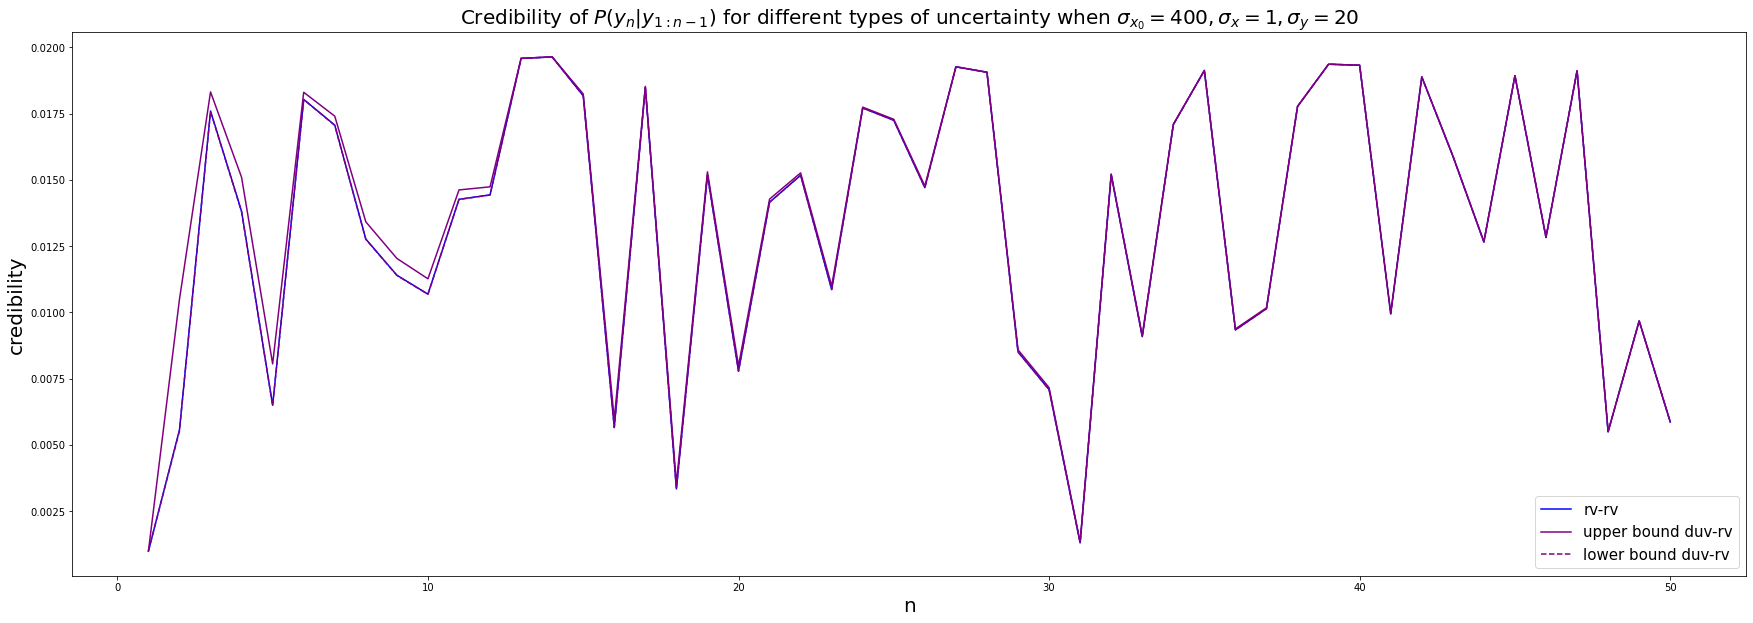

In [116]:
plt.figure(figsize=(30,10))
plt.title("Credibility of $P(y_n| y_{1:n-1})$ for different types of uncertainty when $\sigma_{x_{0}} = 400, \sigma_{x}=1,\sigma_{y}=20$", fontsize = 20)
plt.xlabel('n',fontsize=20)
plt.ylabel('credibility', fontsize=20)
plt.plot(np.arange(start=1, stop=n+1, step=1),cred,linestyle='-',color='blue',label='rv-rv')
#plt.plot(np.arange(start=1, stop=n+1, step=1),B,linestyle='-',color='red',label='duv-duv')
#plt.plot(np.arange(start=1, stop=n+1, step=1),X,linestyle='--',color='red',label='lower bound duv-duv')
plt.plot(np.arange(start=1, stop=n+1, step=1),D,linestyle='-',color='purple',label='upper bound duv-rv')
plt.plot(np.arange(start=1, stop=n+1, step=1),Y,linestyle='--',color='purple',label='lower bound duv-rv')
plt.legend(loc='best',fontsize=15)
plt.show()

Try editing lower bound by $\underset{x_0 \in \mathcal{X}}{min} c - [(c-  p(y_n |y_{1:n-1},x_0))f(x_0)]$ where 
$c = \underset{x_0 \in \mathcal{X}}{max} \hskip0.2cm p(y_n |y_{1:n-1},x_0)$. <br>
If $p(y_n |y_{1:n-1},x_0) = \mathcal{N} (y_n ; ax_0 +b,var) $This means that we will choose $x_0 = (y_n -b)/a$

In [117]:
#another lower bound for subjective prob p(yn|y1:n-1)    
Y1 = [] 
for i in np.arange(n):
    def f(x):
        c = norm(y[0][i], Pyn[i]**0.5).pdf(y[0][i]) #by sbustitute x0= (yn - rem )/coef we get mean = yn 
        return c- ((math.exp((-1/(2*newP00[i]))*((x-newMu0[i])**2 )))* (c-norm(coyn[i]*x + reyn[i], Pyn[i]**0.5).pdf(y[0][i])))
    j = minimize(f,a).x   #try to find how to set initial guess? #set intial guess =a if set a+b/2 will stuck at local min
    Y1.append(f(j))  

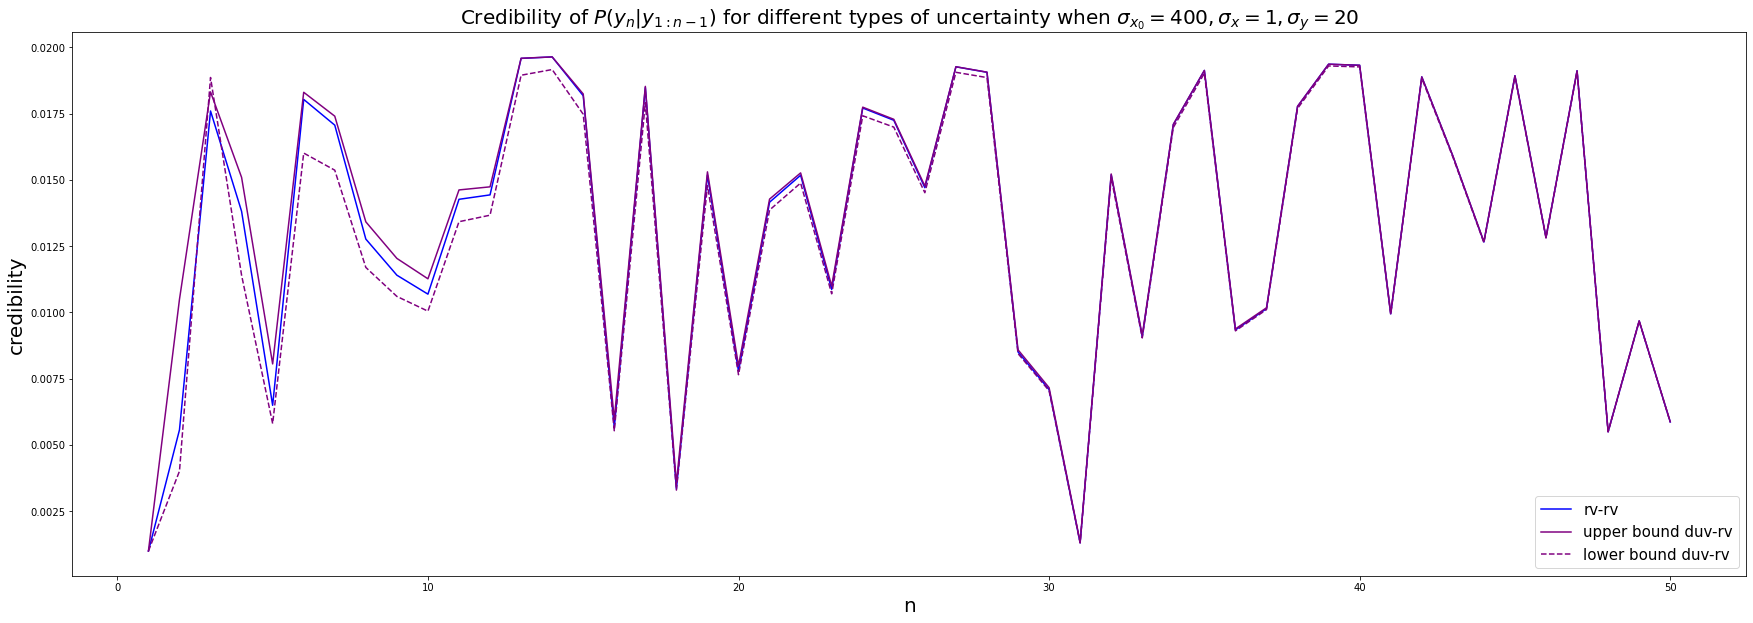

In [118]:
plt.figure(figsize=(30,10))
plt.title("Credibility of $P(y_n| y_{1:n-1})$ for different types of uncertainty when $\sigma_{x_{0}} = 400, \sigma_{x}=1,\sigma_{y}=20$", fontsize = 20)
plt.xlabel('n',fontsize=20)
plt.ylabel('credibility', fontsize=20)
plt.plot(np.arange(start=1, stop=n+1, step=1),cred,linestyle='-',color='blue',label='rv-rv')
#plt.plot(np.arange(start=1, stop=n+1, step=1),B,linestyle='-',color='red',label='duv-duv')
#plt.plot(np.arange(start=1, stop=n+1, step=1),X,linestyle='--',color='red',label='lower bound duv-duv')
plt.plot(np.arange(start=1, stop=n+1, step=1),D,linestyle='-',color='purple',label='upper bound duv-rv')
plt.plot(np.arange(start=1, stop=n+1, step=1),Y1,linestyle='--',color='purple',label='lower bound duv-rv')
plt.legend(loc='best',fontsize=15)
plt.show()